# Question 3: Implement ReAct Agent with Multiple Tools (25 points)

Implement a ReAct (Reasoning and Acting) agent as described by Yao et al. [1], incorporating three main tools: search, compare, and analyze. This agent should be able to handle complex queries by reasoning about which tool to use and when.

a) (4 points) Implement the search tool using the SerpAPI integration from previous questions. Ensure it can be easily used by the ReAct agent.
   - Proper integration with SerpAPI
   - Formatting the search results for use by the ReAct agent

b) (5 points) Create a custom comparison tool using LangChain's `Tool` class. The tool should accept multiple items and a category as input and return a comparison result.
   - Implementing the comparison logic
   - Creating an appropriate prompt template for the comparison
   - Proper error handling for invalid inputs

c) (5 points) Implement an analysis tool that can summarize and extract key information from search results or comparisons. This tool should use the OpenAI model to generate insightful analyses.
   - Implementing the analysis logic
   - Creating an appropriate prompt template for the analysis
   - Ensuring the analysis output is concise and relevant

d) (6 points) Integrate these tools with a ReAct agent using LangChain. Your implementation should:
   - Use LangChain's `initialize_agent` function with the `AgentType.ZERO_SHOT_REACT_DESCRIPTION` agent type
   - Include all three tools (search, compare, analyze) as available actions for the agent
   - Implement proper error handling and fallback strategies
   - Ensure smooth transitions between tools in the agent's reasoning process

e) (5 points) Implement a simple Streamlit user interface for your ReAct agent. Your implementation should include:
   - A text input field for users to enter their queries
   - A button to submit the query and trigger the ReAct agent
   - A display area for showing the final results
   - A section to display the step-by-step reasoning process of the ReAct agent

In [1]:
# Install required packages
!pip install langchain_openai google-search-results langchain
!pip install -U langchain-community

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 9.3 MB/s eta 0:00:00
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=3b2125b0447fe27114c9d758f9c73f18c023bcd625d2f9041ba27b4361e551c9
  Stored in directory: /root/.cache/pip/wheels/0c/47/f5/89b7e770ab2996baf8c910e7

In [2]:
# ensure API KEY in the secrets tab
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["SERPAPI_API_KEY"] = userdata.get("SERPAPI_API_KEY")

print(os.environ.get("OPENAI_API_KEY")[:8])
print( os.environ.get("SERPAPI_API_KEY")[:8])



sk-proj-
6be13d3d


In [7]:
!pip install "langchain==0.2.16" "langchain-community==0.2.16" "langchain-openai==0.1.7"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.4.40
    Uninstalling langsmith-0.4.40:
      Successfully

In [3]:
# Import necessary libraries
from langchain_openai import OpenAI
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate


# Initialize the OpenAI language model
llm = OpenAI(temperature=0)

## a) Implement the search tool
a) (4 points) Implement the search tool using the SerpAPI integration from previous questions. Ensure it can be easily used by the ReAct agent.
   - Proper integration with SerpAPI
   - Formatting the search results for use by the ReAct agent


In [19]:
# Load the search tool using SerpAPI
from serpapi.google_search import GoogleSearch

class SearchTool:
    """Search Tool using SerpAPI to get search results suitable for ReAct."""
    is_single_input = True
    name = "search_tool"
    description = "Performs a web search based on the user's query."

    def __init__(self):
        api_key = os.environ.get("SERPAPI_API_KEY")
        if not api_key:
            raise ValueError("SERPAPI_API_KEY is not set in environment.")
        self.api_key = api_key

    def __call__(self, query: str) -> str:
        search = GoogleSearch({
            "q": query,
            "api_key": self.api_key,
            "engine": "google",
            "num": 5, # top 5 results
        })

        data = search.get_dict()

        if "error" in data:
            return f"SerpAPI error: {data['error']}"

        results = data.get("organic_results", [])
        if not results:
            return "No search results found."

        lines = []
        for i, r in enumerate(results, start=1):
            title = r.get("title", "No title")
            link = r.get("link", "No link")
            snippet = r.get("snippet", "")[:200]

            lines.append(
                f"[{i}] {title}\n"
                f"URL: {link}\n"
                f"Snippet: {snippet}..."
            )

        return "\n\n".join(lines)

In [20]:
search_tool = SearchTool()

# tool object
search_tool_for_agent = Tool(
    name="web_search",
    func=search_tool,
    description=(
        "Use this tool to search the web for up-to-date information. "
        "Input should be a natural language search query."
    ),
)


In [21]:
test_query = "latest LLM benchmark results on MMLU and GSM8K"
print("Search Results:\n")
print(search_tool(test_query))

Search Results:

[1] 40 Large Language Model Benchmarks and The Future of ...
URL: https://arize.com/blog/llm-benchmarks-mmlu-codexglue-gsm8k/
Snippet: This blog will discuss some of the most popular LLM benchmarks for evaluating top models like GPT 4o, Gemma 3, or Claude....

[2] LLM Leaderboard 2025
URL: https://www.vellum.ai/llm-leaderboard
Snippet: This LLM leaderboard displays the latest public benchmark performance for SOTA model versions released after April 2024....

[3] How to evaluate and benchmark Large Language Models ...
URL: https://www.together.ai/blog/evaluate-and-benchmark-llms
Snippet: Learn how to evaluate and benchmark large language models using datasets like MMLU, GSM8K, and HumanEval. Going further, we'll also explore ......

[4] LLM Leaderboard | Compare Top AI Models for 2024
URL: https://yourgpt.ai/tools/llm-comparison-and-leaderboard
Snippet: GSM8K (Grade-School Mathematics 8K) is a benchmark focused on evaluating a model's mathematical capabilities. It inclu

## b) Create a custom comparison tool

b) (5 points) Create a custom comparison tool using LangChain's `Tool` class. The tool should accept multiple items and a category as input and return a comparison result.
   - Implementing the comparison logic
   - Creating an appropriate prompt template for the comparison
   - Proper error handling for invalid inputs

In [22]:
# comparison prompt

comparison_prompt = PromptTemplate(
    input_variables=["items", "category"],
    template=(
        "You are a comparison expert. Compare the following items based on the category '{category}'.\n\n"
        "Items:\n{items}\n\n"
        "Provide a concise, structured, and clear comparison."
    ),
)

In [23]:
comparison_chain = LLMChain(llm=llm, prompt=comparison_prompt)

/tmp/ipython-input-2546925915.py:1: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  comparison_chain = LLMChain(llm=llm, prompt=comparison_prompt)


In [24]:
def compare_items(query: str) -> str:
    """
    Compare items based on the query.
    Expected query format: "Compare [item1, item2, item3] based on 'category'"
    """
    try:
        # Extract items and category from the query
        items_start = query.find("[") + 1
        items_end = query.find("]")
        category_start = query.find("based on '") + len("based on '")
        category_end = query.find("'", category_start)

        if items_start == 0 or items_end == -1 or category_start == -1:
            return (
                "Invalid input format. Use the format: "
                "Compare [item1, item2, item3] based on 'category'"
            )

        # Parse the result
        items = query[items_start:items_end].split(", ")
        category = query[category_start:category_end]
        items_str = ", ".join(items)

        # Run the comparison
        result = comparison_chain.run({"items": items_str, "category": category})
        return result

    except Exception as e:
        return f"Error in comparison: {e}"

In [25]:
# wrap in LangChain Tool

comparison_tool = Tool(
    name="comparison_tool",
    func=compare_items,
    description=(
        "Compares multiple items based on a specified category and returns a concise comparison."
    ),
)

In [26]:
query = "Compare [GPT-4, Claude 3, Gemini 1.5] based on 'reasoning ability'"
comparison_result = comparison_tool.run(query)
print("Comparison Result:\n", comparison_result)

/tmp/ipython-input-1586394700.py:25: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  result = comparison_chain.run({"items": items_str, "category": category})


Comparison Result:
 

When it comes to reasoning ability, GPT-4, Claude 3, and Gemini 1.5 are all impressive contenders. GPT-4, the latest version of the GPT series, is known for its advanced natural language processing capabilities and ability to generate human-like text. Claude 3, on the other hand, is a highly intelligent AI designed specifically for problem-solving and logical reasoning tasks. Lastly, Gemini 1.5 is a cutting-edge AI that excels in both analytical and creative thinking, making it a well-rounded reasoning machine.

In terms of sheer processing power, GPT-4 stands out with its massive neural network and ability to process vast amounts of data. However, Claude 3's specialized programming for reasoning tasks gives it an edge in terms of accuracy and efficiency. Gemini 1.5, while not as powerful as GPT-4, makes up for it with its versatility and ability to think outside the box.

When it comes to adaptability, GPT-4 and Gemini 1.5 have the upper hand, as they are both de

## c) Implement an analysis tool
c) (5 points) Implement an analysis tool that can summarize and extract key information from search results or comparisons. This tool should use the OpenAI model to generate insightful analyses.
   - Implementing the analysis logic
   - Creating an appropriate prompt template for the analysis
   - Ensuring the analysis output is concise and relevant

In [27]:
# define prompt templete

analyze_prompt_template = """
You are an expert analyst. Based on the following results, generate an insightful analysis.

- Provide a concise summary that highlights key information, pros, and cons if relevant.
- If the results involve a comparison, highlight the main differences, strengths, and weaknesses of each item.
- Focus only on the most important points that would help a user make a decision.

Results:
{results}

Instructions:
1. Start with a brief overview if it's from search results.
2. If it's a comparison, include specific pros and cons for each item.
3. Keep the answer concise and directly relevant to the user's needs.
"""

# PromptTemplate for the analyze tool
analyze_prompt = PromptTemplate(
    input_variables=["results"],
    template=analyze_prompt_template,
)

# generate LLMChain
analyze_chain = LLMChain(llm=llm, prompt=analyze_prompt)

In [31]:
# New function to analyze search results and perform comparisons
def analyze_results(results: str) -> str:
    """Uses LLM to analyze and summarize the search or comparison results."""
    try:
        analysis = analyze_chain.run({"results": results})
        return analysis.strip()
    except Exception as e:
        return f"Error during analysis: {e}"

# wrapping via LangChain Tool
analyze_tool = Tool(
    name="analyze_tool",
    func=analyze_results,
    description=(
        "Generates concise and insightful analyses or summaries based on "
        "search or comparison results."
    ),
)

In [38]:
# get search query
search_query = "Compare top 2025 flagship smartphones for camera and battery life"
search_results_text = search_tool(search_query)

print("--- Raw Search Results ---")
print(search_results_text[:800])

# use analysis tools
analysis_from_search = analyze_tool.run(search_results_text)

print("\n--- Analysis of Search Results ---")
print(analysis_from_search)

--- Raw Search Results ---
[1] The Best Phones We've Tested for 2025
URL: https://www.pcmag.com/picks/the-best-phones
Snippet: The Best Phones for 2025 ; Best iPhone for Most People. Apple iPhone 17 · Best value among iPhone 17 models · No telephoto camera ; Best Midrange ......

[2] Best Phones in 2025 | Top-Rated Smartphones ... - CNET
URL: https://www.cnet.com/tech/mobile/best-phone/
Snippet: From Apple's iPhone Air and iPhone 17 family to Samsung's Galaxy S25 series and foldable phones like the Motorola Razr Ultra and Galaxy Z Fold 7 ......

[3] The best camera phone 2025: top mobiles for photography
URL: https://www.techradar.com/news/best-cameraphone
Snippet: The best camera phone 2025 · Apple iPhone 17 Pro Max camera samples · Galaxy S25 Ultra camera samples · OnePlus 13 camera samples · Google Pixel 10 .....

--- Analysis of Search Results ---
The results show the best phones for 2025 from various sources, including PCMag, CNET, TechRadar, Amateur Photographer, and GSM Arena. T

## d) Integrate tools with a ReAct agent
d) (6 points) Integrate these tools with a ReAct agent using LangChain. Your implementation should:
   - Use LangChain's `initialize_agent` function with the `AgentType.ZERO_SHOT_REACT_DESCRIPTION` agent type
   - Include all three tools (search, compare, analyze) as available actions for the agent
   - Implement proper error handling and fallback strategies
   - Ensure smooth transitions between tools in the agent's reasoning process

In [33]:
# Integrate tools with ReAct agent
"""
- search_tool_for_agent
- comparison_tool
- analyze_tool
"""
tools = [search_tool_for_agent, comparison_tool, analyze_tool]

In [34]:
# tool usage instruction
def create_instructional_query(user_query: str) -> str:
    instructional_query = f"""
You are an intelligent ReAct-style agent with access to the following tools:

1. web_search
   - Use this to gather detailed and up-to-date information from the web.

2. comparison_tool
   - Use this to compare multiple items based on a specific category
     (e.g., performance, price, battery life, etc.).

3. analyze_tool
   - Use this to analyze and summarize search or comparison results and
     produce a final, concise answer for the user.

Instructions:
- Decide when to call web_search to obtain information.
- If the query involves comparing multiple options, call comparison_tool.
- After gathering enough information, call analyze_tool to generate
  a clear, concise final response.
- You may call the tools multiple times and switch between them as needed.
- Follow a ReAct style: Thought -> Action -> Observation -> ... -> Final Answer.

User query:
\"\"\"{user_query}\"\"\"
"""
    return instructional_query.strip()

In [35]:
# Initialize the agent with three tools
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True, # Thought / Action / Observation log
    handle_parsing_errors=True, # error recovery
)

/tmp/ipython-input-2297059972.py:2: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 1.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  agent = initialize_agent(


In [36]:
def process_query(query: str, max_steps: int = 100) -> str:
    """
    Runs the ReAct agent with the given query.
    Adds instruction for using tools, and handles errors gracefully.
    """
    try:
        instructional_query = create_instructional_query(query)
        return agent.run(instructional_query)
    except RecursionError:
        return (
            "The query was too complex and exceeded the maximum number of steps. "
            "Please try a simpler query."
        )
    except Exception as e:
        return f"An error occurred: {str(e)}"

In [37]:
sample_query = (
    "Compare the camera and battery performance of the latest iPhone and "
    "Samsung Galaxy models, and tell me which one is better overall."
)

final_answer = process_query(sample_query)
print("\n=== Final Answer from ReAct Agent ===\n")
print(final_answer)



> Entering new AgentExecutor chain...
 I should use the comparison_tool to compare the camera and battery performance of the latest iPhone and Samsung Galaxy models.
Action: comparison_tool
Action Input: "camera and battery performance of latest iPhone and Samsung Galaxy models"
Observation: Invalid input format. Use the format: Compare [item1, item2, item3] based on 'category'
Thought: I should modify the input to match the required format.
Action: comparison_tool
Action Input: "Compare [iPhone, Samsung Galaxy] based on 'camera and battery performance'"
Observation: 

When it comes to camera and battery performance, the iPhone and Samsung Galaxy are two of the top contenders in the smartphone market. Both devices offer high-quality cameras and long-lasting battery life, but there are some key differences to consider.

Camera Performance:
The iPhone is known for its exceptional camera quality, with its latest models featuring dual or triple-lens cameras and advanced features such as 

## Test Your Implementation

Use the cell below to test your implementation with a sample query.

In [39]:
# Test your implementation
sample_query = "What are the top 3 smartphones in 2023, and how do they compare in terms of camera quality and battery life?"

result = process_query(sample_query)
print(result)



> Entering new AgentExecutor chain...
 I should use web_search to gather information about the top smartphones in 2023.
Action: web_search
Action Input: "top smartphones 2023"
Observation: [1] My Favorite Phones Of 2023: Something For Everyone
URL: https://www.forbes.com/sites/moorinsights/2024/01/23/my-favorite-phones-of-2023-something-for-everyone/
Snippet: Favorite Overall Phone — Tie: Samsung Galaxy S23 Ultra And iPhone 15 Pro Max · Favorite Phone Camera — Google Pixel 8 Pro · Favorite Flip Phone — ......

[2] Pickr's Best Picks: The best phones of 2023
URL: https://www.pickr.com.au/buyers-guide/2023/pickrs-best-picks-the-best-phones-of-2023/
Snippet: Best Android phone: Google Pixel 8 Pro · Best iPhone: Apple iPhone 15 Pro Max · Best foldable phone: Motorola Razr 40 Ultra · Best value phone: ......

[3] Best US market phones of 2023 - buyer's guide
URL: https://www.gsmarena.com/best_usa_market_phones-review-2358.php
Snippet: The Motorola Edge+ (2023) is a pure flagship sold at a

e) (5 points) Implement a simple Streamlit user interface for your ReAct agent. Your implementation should include:
   - A text input field for users to enter their queries
   - A button to submit the query and trigger the ReAct agent
   - A display area for showing the final results
   - A section to display the step-by-step reasoning process of the ReAct agent

In [41]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 48.5 MB/s eta 0:00:00


In [42]:
# write app.py to run in streamlit
## tools - copy and paste above code

%%writefile app.py
import os
import io
import contextlib

import streamlit as st
from langchain_openai import OpenAI
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from serpapi.google_search import GoogleSearch

llm = OpenAI(temperature=0)


# SearchTool (SerpAPI)
class SearchTool:
    """Search Tool using SerpAPI to get search results suitable for ReAct."""
    is_single_input = True
    name = "web_search"
    description = (
        "Use this tool to search the web for up-to-date information. "
        "Input should be a natural language search query."
    )

    def __init__(self):
        api_key = os.environ.get("SERPAPI_API_KEY")
        if not api_key:
            raise ValueError("SERPAPI_API_KEY is not set in environment.")
        self.api_key = api_key

    def __call__(self, query: str) -> str:
        """Search using SerpAPI and format results."""
        search = GoogleSearch({
            "q": query,
            "api_key": self.api_key,
            "engine": "google",
            "num": 5,
        })
        data = search.get_dict()

        if "error" in data:
            return f"SerpAPI error: {data['error']}"

        results = data.get("organic_results", [])
        if not results:
            return "No search results found."

        lines = []
        for i, r in enumerate(results, start=1):
            title = r.get("title", "No title")
            link = r.get("link", "No link")
            snippet = r.get("snippet", "")[:200]
            lines.append(
                f"[{i}] {title}\n"
                f"URL: {link}\n"
                f"Snippet: {snippet}..."
            )
        return "\n\n".join(lines)


search_tool_impl = SearchTool()

search_tool_for_agent = Tool(
    name="web_search",
    func=search_tool_impl,
    description=SearchTool.description,
)


# Comparison Tool
comparison_prompt = PromptTemplate(
    input_variables=["items", "category"],
    template=(
        "You are a comparison expert. Compare the following items based on "
        "the category '{category}'.\n\n"
        "Items:\n{items}\n\n"
        "Provide a concise, structured, and clear comparison."
    ),
)

comparison_chain = LLMChain(llm=llm, prompt=comparison_prompt)


def compare_items(query: str) -> str:
    """
    Expected query format:
    Compare [item1, item2, item3] based on 'category'
    """
    try:
        items_start = query.find("[") + 1
        items_end = query.find("]")
        category_start = query.find("based on '") + len("based on '")
        category_end = query.find("'", category_start)

        if items_start == 0 or items_end == -1 or category_start == -1:
            return (
                "Invalid input format. Use the format: "
                "Compare [item1, item2, item3] based on 'category'"
            )

        items = query[items_start:items_end].split(", ")
        category = query[category_start:category_end]
        items_str = ", ".join(items)

        result = comparison_chain.run({"items": items_str, "category": category})
        return result.strip()
    except Exception as e:
        return f"Error in comparison: {e}"


comparison_tool = Tool(
    name="comparison_tool",
    func=compare_items,
    description="Compares multiple items based on a specified category and returns a concise comparison.",
)


# Analysis Tool
analyze_prompt_template = """
You are an expert analyst. Based on the following results, generate an insightful analysis.

- Provide a concise summary that highlights key information, pros, and cons if relevant.
- If the results involve a comparison, highlight the main differences, strengths, and weaknesses of each item.
- Focus only on the most important points that would help a user make a decision.

Results:
{results}

Instructions:
1. Start with a brief overview if it's from search results.
2. If it's a comparison, include specific pros and cons for each item.
3. Keep the answer concise and directly relevant to the user's needs.
"""

analyze_prompt = PromptTemplate(
    input_variables=["results"],
    template=analyze_prompt_template,
)

analyze_chain = LLMChain(llm=llm, prompt=analyze_prompt)


def analyze_results(results: str) -> str:
    """Uses LLM to analyze and summarize the search or comparison results."""
    try:
        analysis = analyze_chain.run({"results": results})
        return analysis.strip()
    except Exception as e:
        return f"Error during analysis: {e}"


analyze_tool = Tool(
    name="analyze_tool",
    func=analyze_results,
    description=(
        "Generates concise and insightful analyses or summaries based on "
        "search or comparison results."
    ),
)


# ReAct Agent
tools = [search_tool_for_agent, comparison_tool, analyze_tool]


def create_instructional_query(user_query: str) -> str:
    return f"""
You are an intelligent ReAct-style agent with access to the following tools:

1. web_search
   - Use this to gather detailed and up-to-date information from the web.

2. comparison_tool
   - Use this to compare multiple items based on a specific category
     (e.g., performance, price, battery life, etc.).

3. analyze_tool
   - Use this to analyze and summarize search or comparison results and
     produce a final, concise answer for the user.

Instructions:
- Decide when to call web_search to obtain information.
- If the query involves comparing multiple options, call comparison_tool.
- After gathering enough information, call analyze_tool to generate
  a clear, concise final response.
- You may call the tools multiple times and switch between them as needed.
- Follow a ReAct style: Thought -> Action -> Observation -> ... -> Final Answer.

User query:
\"\"\"{user_query}\"\"\"
""".strip()


agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True,
)


def run_agent_with_trace(query: str, max_steps: int = 20):
    """
    run ReAct agent + stdout log (Thought/Action/Observation)
    """
    buf = io.StringIO()
    instructional_query = create_instructional_query(query)

    with contextlib.redirect_stdout(buf):
        result = agent.run(instructional_query)

    trace = buf.getvalue()
    return result, trace


# Streamlit UI

st.title("ReAct Agent Demo: Search, Compare, Analyze")

st.write(
    "Enter a complex question. The ReAct agent can search the web, "
    "compare multiple options, and analyze the results to give you a final answer."
)

user_query = st.text_area(
    "Your question:",
    height=120,
    placeholder="e.g., Compare the top smartphones of 2023 in terms of camera and battery life.",
)

max_steps = st.slider("Maximum reasoning steps (hint to agent)", 1, 50, 20)

if st.button("Run ReAct Agent"):
    if not user_query.strip():
        st.warning("Please enter a question.")
    else:
        with st.spinner("Agent is thinking..."):
            final_answer, trace = run_agent_with_trace(user_query, max_steps=max_steps)

        st.subheader("Final Answer")
        st.write(final_answer)

        st.subheader("ReAct Reasoning Trace (Thought / Action / Observation)")
        st.text(trace)


Writing app.py


Get your Ngrok auth-token, and set in 'Secret' tab

In [45]:
from pyngrok import ngrok

os.environ["NGROK_AUTHTOKEN"] = userdata.get("NGROK_AUTHTOKEN")
ngrok.set_auth_token(os.environ["NGROK_AUTHTOKEN"])

In [48]:
public_url = ngrok.connect(8501)
print("Streamlit public URL:", public_url)

Streamlit public URL: NgrokTunnel: "https://12150bb93673.ngrok-free.app" -> "http://localhost:8501"


In [49]:
!streamlit run app.py --server.port 8501 --server.headless true




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.236.216:8501

/content/app.py:82: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  comparison_chain = LLMChain(llm=llm, prompt=comparison_prompt)
/content/app.py:195: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 1.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  agent = initialize_agent(
/content/app.py:212: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  result = agent.run(instructional_query)
  Stopping...
  Stopping...


After running previous cell and connecting to "https://12150bb93673.ngrok-free.app" website, we can see the following screen:


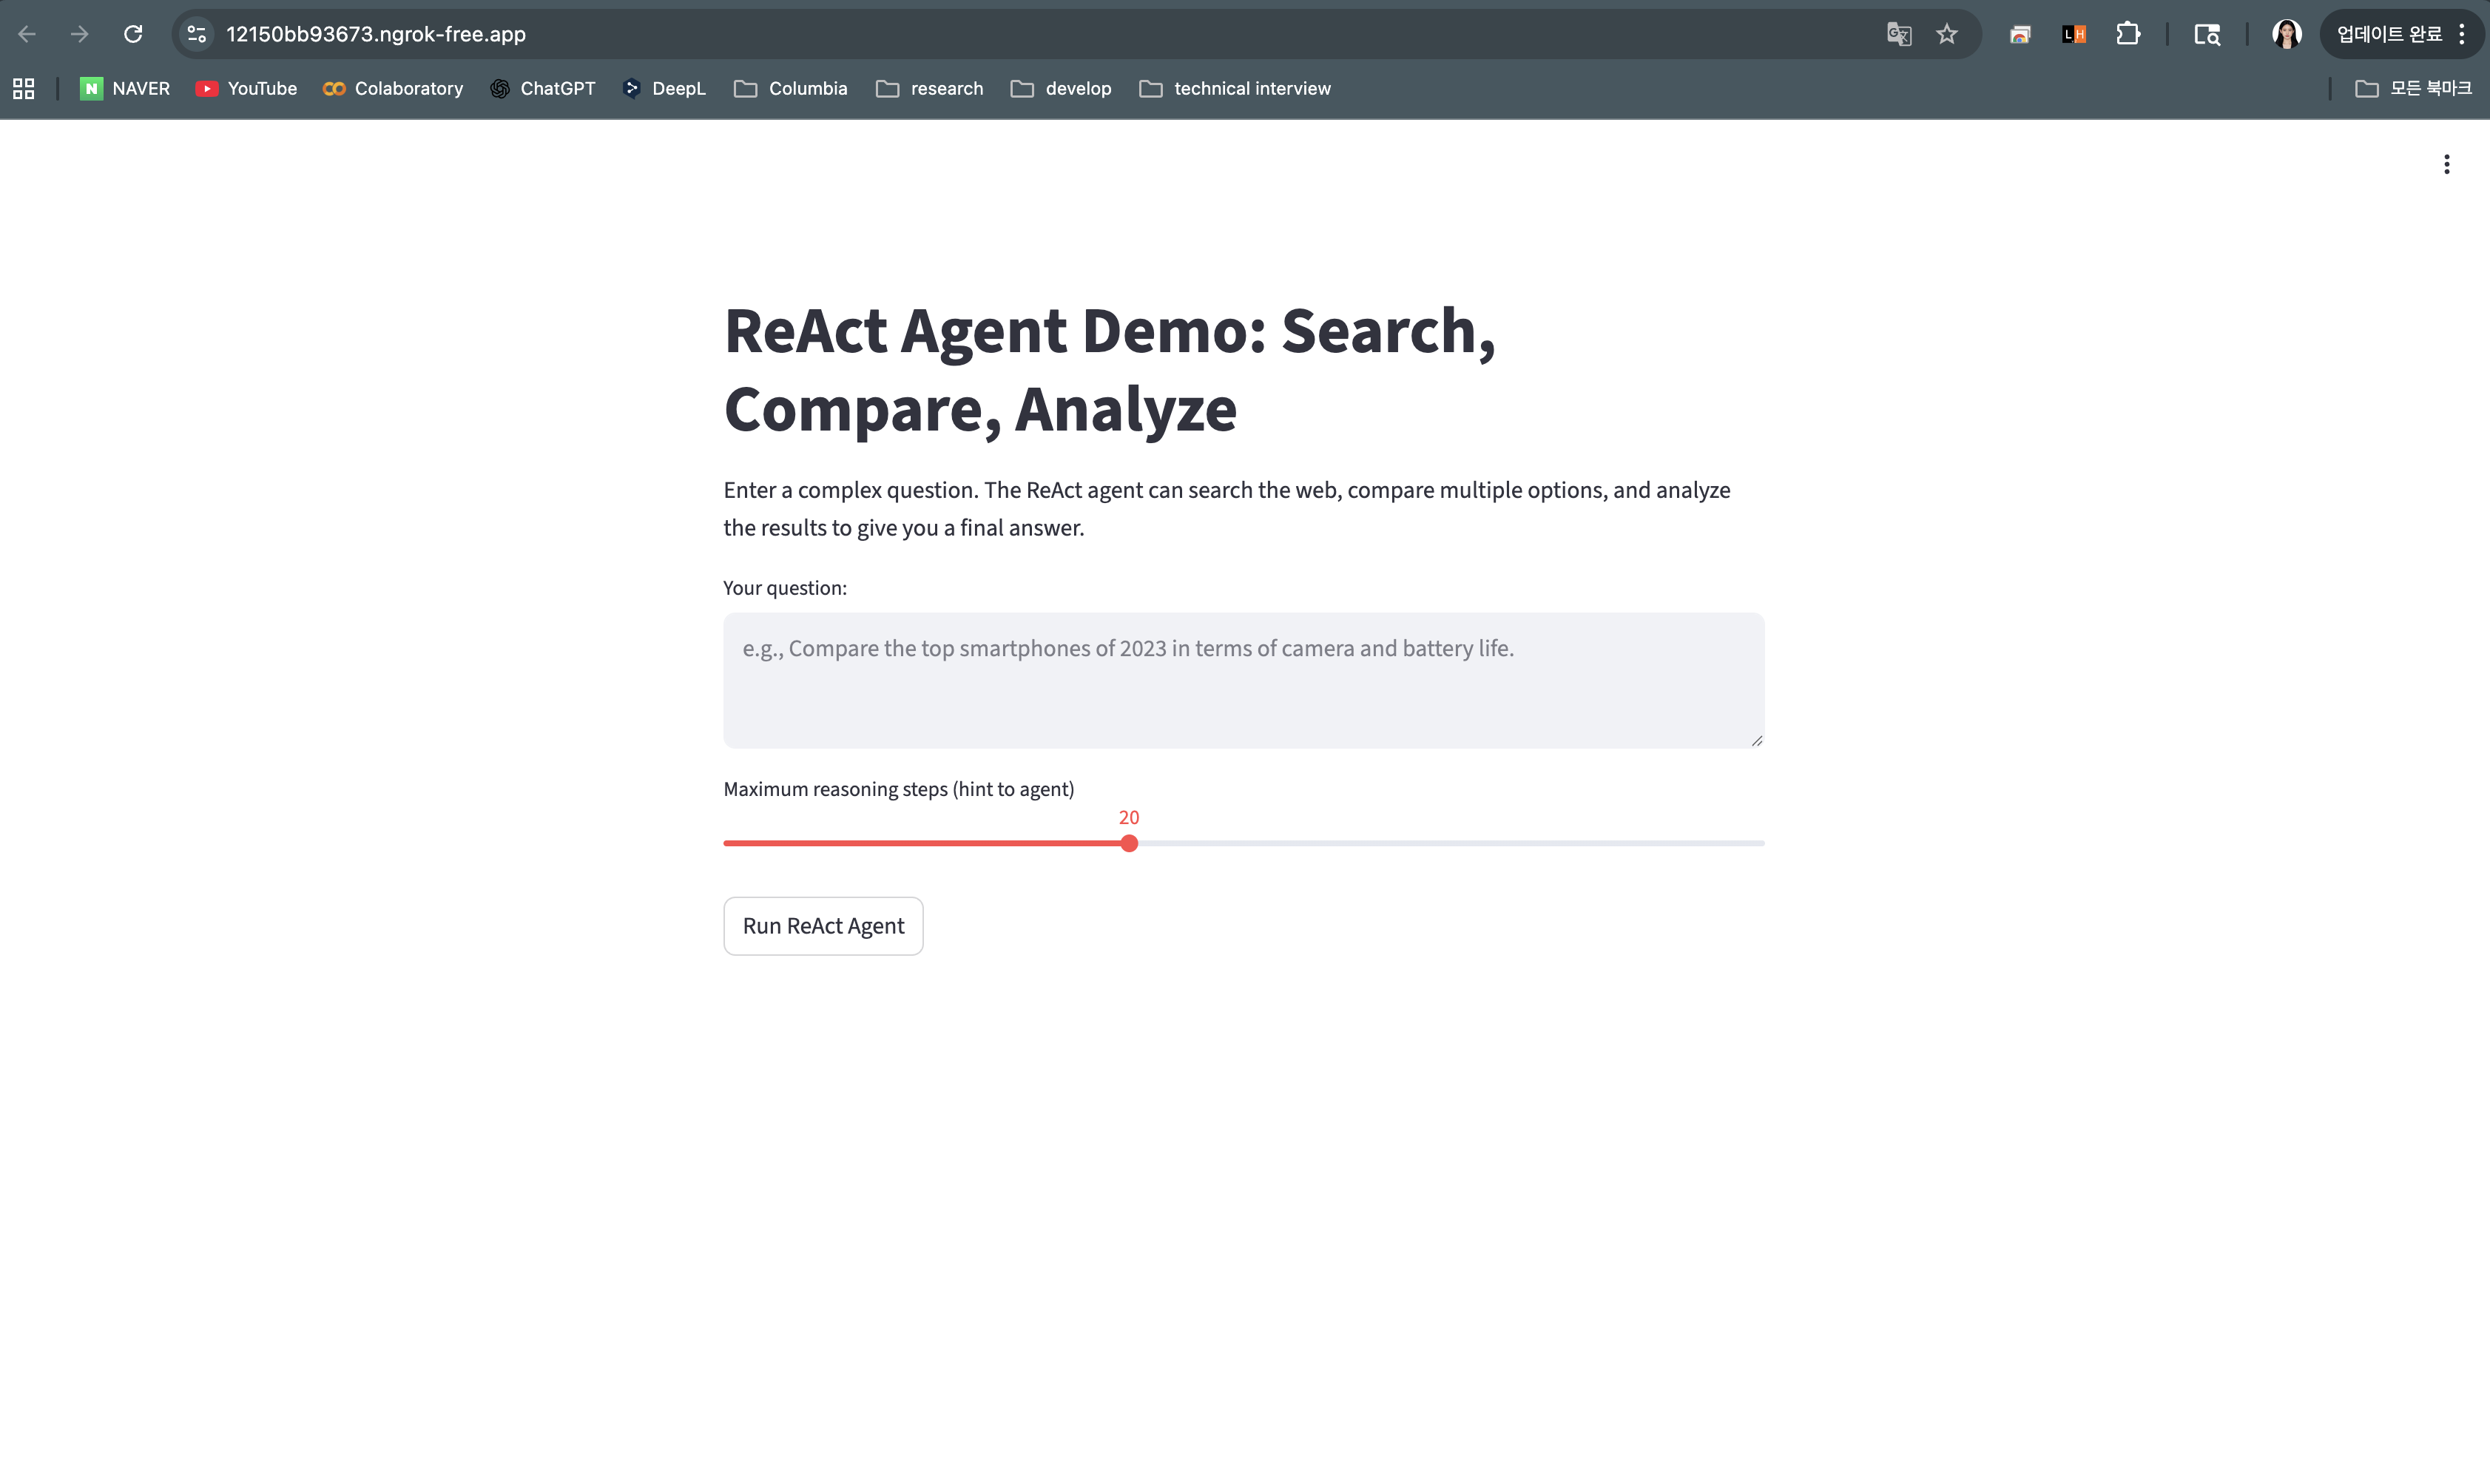


If entering some query, we can check Agent's final output as well as thinking process.
- example query: Which electric vehicles in 2025 have the best range and charging performance? Compare Tesla, Hyundai, and BMW.
- Output





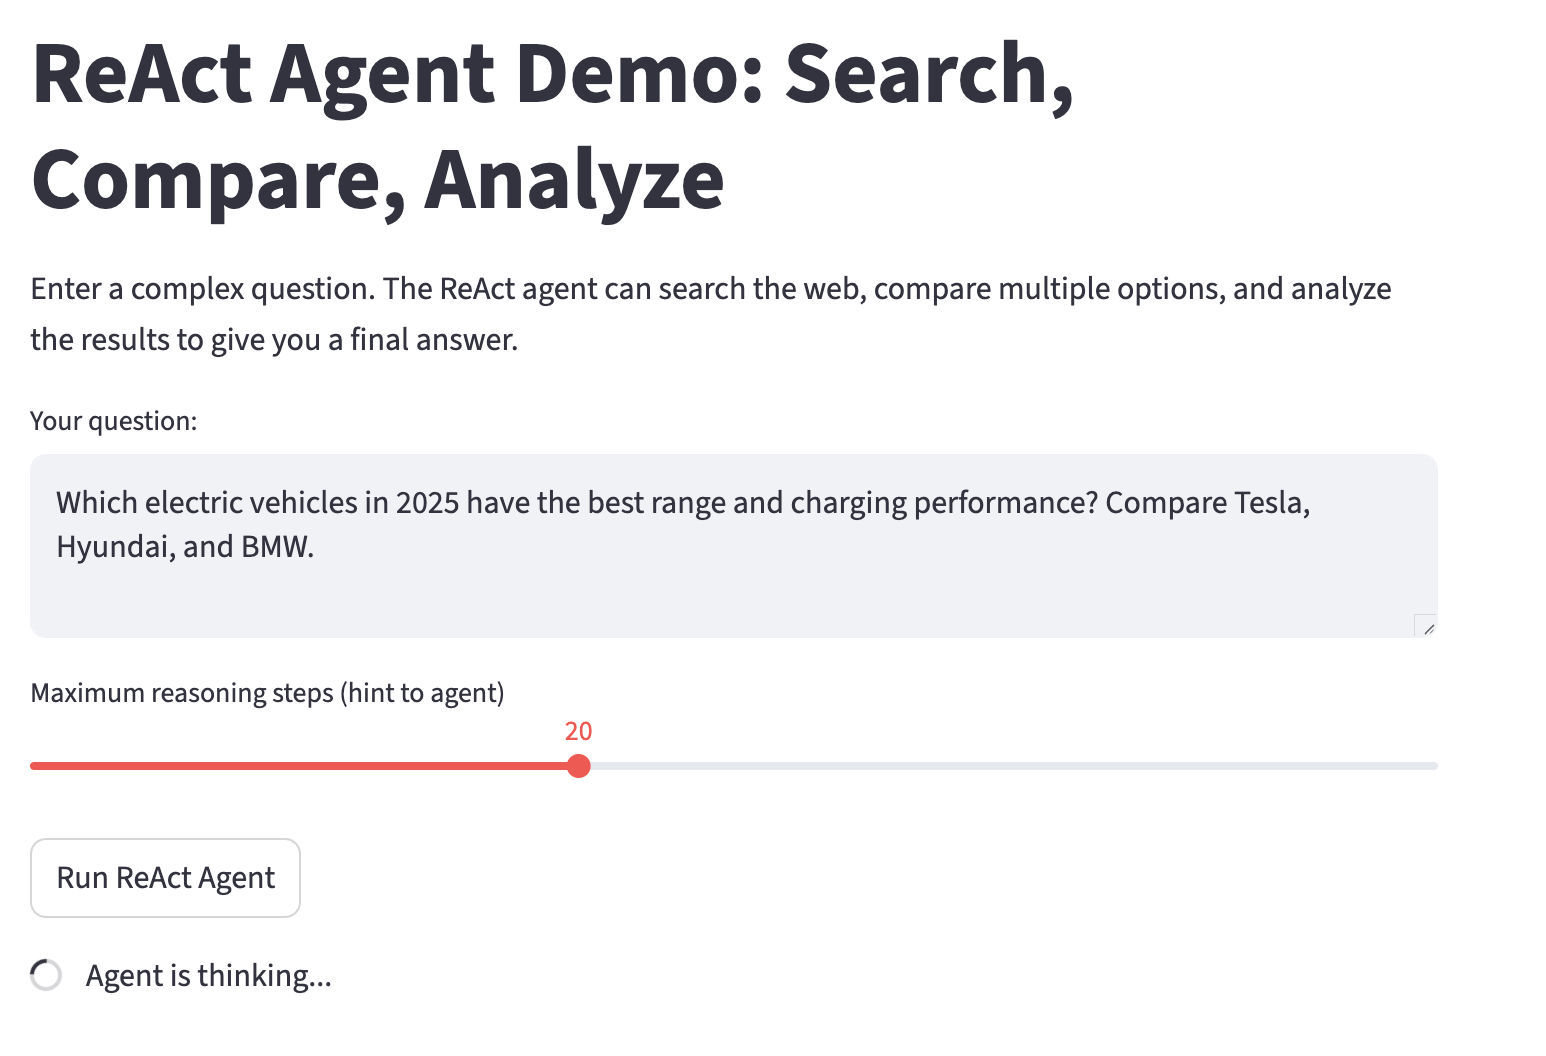

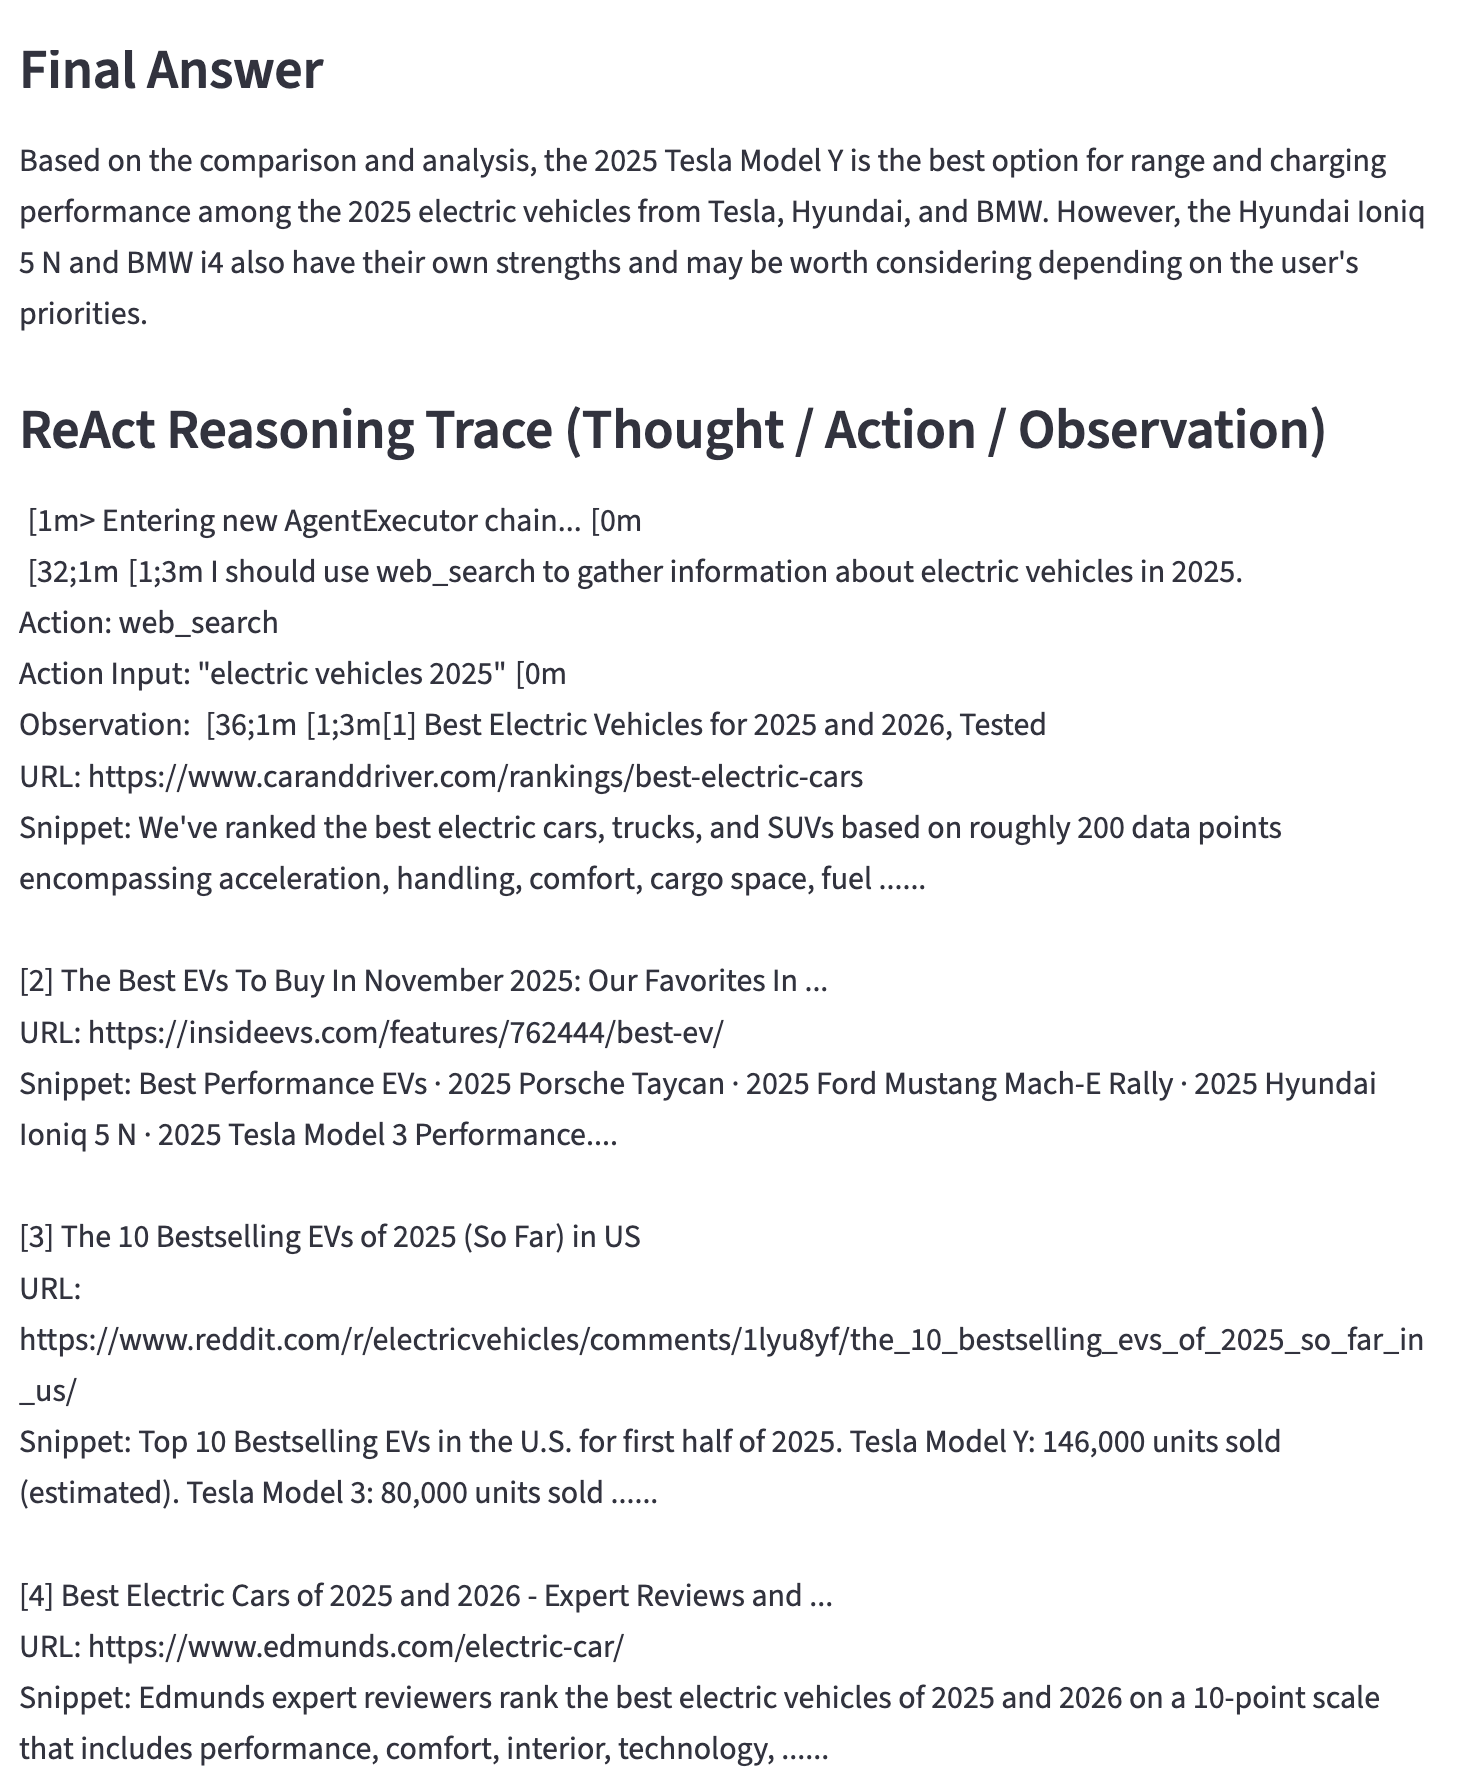

## Submission Requirements

Please submit the following items as part of your solution:

1. Your complete code implementation for the ReAct agent and its tools.
2. A sample question that you used to test your tool (make it complex enough to demonstrate the use of multiple tools).
3. The final answer provided by your ReAct agent for the sample question.
4. The complete history traces of the ReAct agent for your sample question, showing its thought process, actions, and observations. Your traces should follow a format similar to this example:

```
Thought: I need to find information about top smartphones first
Action: Search[top smartphones 2023]
Observation: [Search results about top smartphones]
Thought: Now I should compare the top two options
Action: Compare[iPhone 14 Pro, Samsung Galaxy S23 Ultra, smartphones]
Observation: [Comparison result]
Thought: I should analyze this comparison for the user
Action: Analyze[comparison result]
Observation: [Analysis of the comparison]
Final Answer: [Your agent's final response to the user's query]
```

Ensure that your submission clearly demonstrates the agent's ability to reason about which tool to use and how to interpret the results from each tool. Your history traces should show a logical flow of thoughts, actions, and observations, culminating in a final answer that addresses the initial query.

**Note:** Ensure that your ReAct agent can seamlessly switch between these tools based on the task at hand. The agent should be able to reason about which tool to use next and how to interpret the results from each tool.

## References

[1] Yao, S., Zhao, J., Yu, D., Du, N., Shafran, I., Narasimhan, K., & Cao, Y. (2022). ReAct: Synergizing reasoning and acting in language models. arXiv preprint arXiv:2210.03629. https://arxiv.org/pdf/2210.03629